#  Car Price Prediction 

## Importing The Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Loading the Dataset

In [2]:
df = pd.read_csv("CarPrice_Assignment.csv")  

# Make a working copy
df1 = df.copy()

In [3]:
df1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [4]:
# Basic Info
print("Shape of the dataset:", df.shape)
print("\nColumn Names:\n", df.columns)
print("\nDataset Info:")
print(df.info())

Shape of the dataset: (205, 26)

Column Names:
 Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 


In [5]:
df.isnull().sum().sum()

np.int64(0)

In [6]:
# Extract car company and fix typos
df1['CarCompany'] = df1['CarName'].apply(lambda x: x.split(' ')[0].lower())
df1['CarCompany'] = df1['CarCompany'].replace({
    'vw': 'volkswagen',
    'vokswagen': 'volkswagen',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'maxda': 'mazda',
    'Nissan': 'nissan'
})

In [7]:
# Drop redundant index & original name
df1.drop(['car_ID', 'CarName'], axis=1, inplace=True)

In [8]:
# Info
print("Shape:", df1.shape)
df1.head()

Shape: (205, 25)


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


In [9]:
# Check categorical and numerical columns
cat_cols = df1.select_dtypes(include=['object']).columns
num_cols = df1.select_dtypes(include=['int64', 'float64']).columns

print("Categorical Columns:\n", cat_cols)
print("\nNumerical Columns:\n", num_cols)

Categorical Columns:
 Index(['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem',
       'CarCompany'],
      dtype='object')

Numerical Columns:
 Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price'],
      dtype='object')


## One Hot Encoding Using For Loop

In [10]:
le = LabelEncoder()
for col in cat_cols:
    df1[col] = le.fit_transform(df1[col])

In [11]:
df1.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarCompany
0,3,1,0,1,0,2,0,88.6,168.8,64.1,...,5,3.47,2.68,9.0,111,5000,21,27,13495.0,0
1,3,1,0,1,0,2,0,88.6,168.8,64.1,...,5,3.47,2.68,9.0,111,5000,21,27,16500.0,0
2,1,1,0,1,2,2,0,94.5,171.2,65.5,...,5,2.68,3.47,9.0,154,5000,19,26,16500.0,0
3,2,1,0,0,3,1,0,99.8,176.6,66.2,...,5,3.19,3.40,10.0,102,5500,24,30,13950.0,1
4,2,1,0,0,3,0,0,99.4,176.6,66.4,...,5,3.19,3.40,8.0,115,5500,18,22,17450.0,1


## Independent and Dependent

In [12]:
# Final X,y
X = df1.drop('price', axis=1)
y = df1['price']

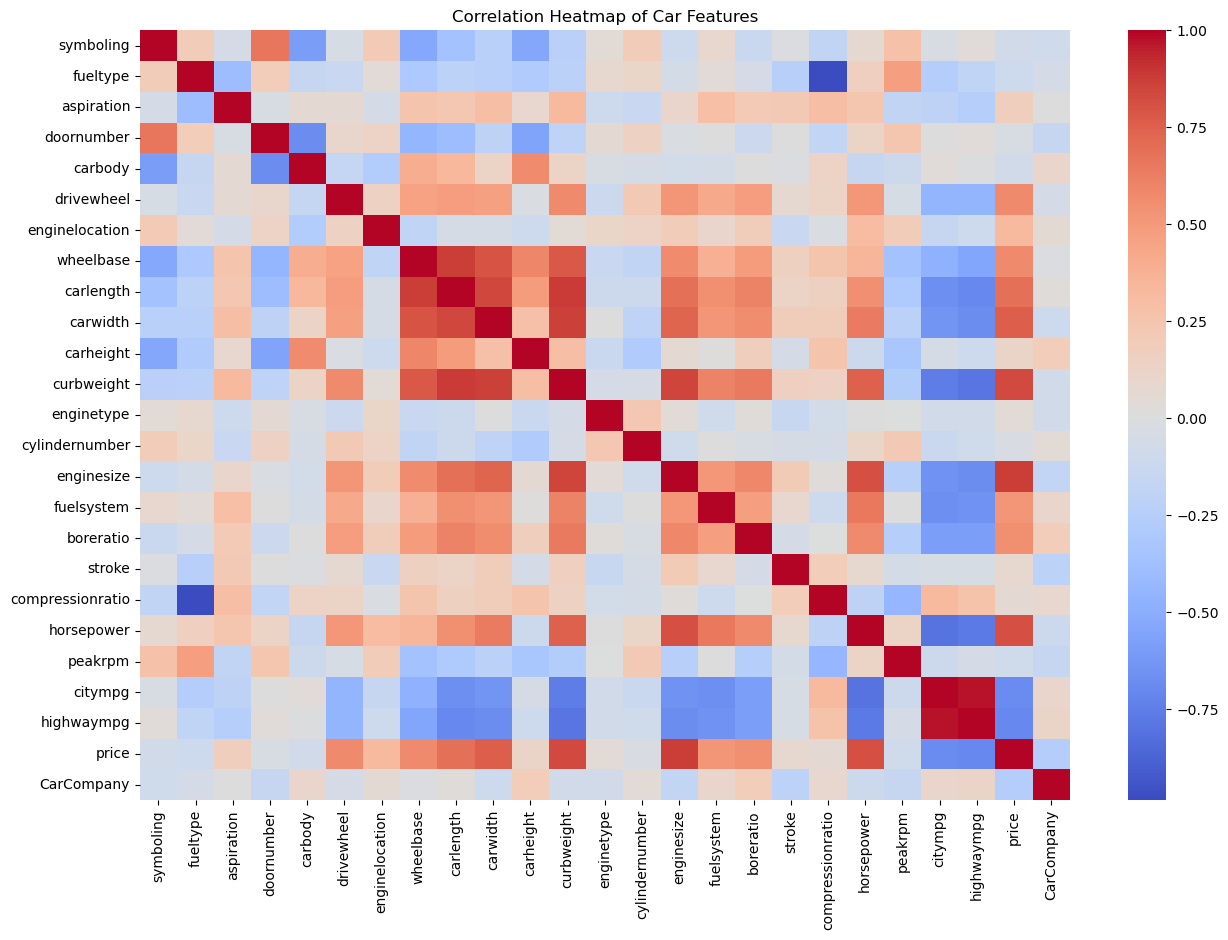

In [13]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df1.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Car Features")
plt.show()

## Variance Inflation Factor

In [14]:
X_const = sm.add_constant(X)
vif = pd.DataFrame()
vif['Feature'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print("Initial VIF:\n", vif.sort_values('VIF', ascending=False).reset_index(drop=True))

Initial VIF:
              Feature          VIF
0              const  8576.048046
1           fueltype   105.191446
2   compressionratio    96.492150
3            citympg    32.863935
4         highwaympg    28.305601
5         curbweight    19.076438
6         horsepower    15.382586
7         enginesize    14.097802
8          carlength    11.853256
9          wheelbase    10.894587
10          carwidth     8.970503
11        aspiration     3.327871
12         carheight     3.094709
13        doornumber     2.838674
14         symboling     2.831253
15           carbody     2.792249
16           peakrpm     2.770458
17        fuelsystem     2.607818
18        drivewheel     2.598306
19         boreratio     2.542395
20    cylindernumber     2.258536
21    enginelocation     1.751142
22        enginetype     1.616111
23        CarCompany     1.605756
24            stroke     1.584316


In [15]:
# Drop high-VIF features
drop_cols = ['wheelbase', 'carlength', 'carwidth', 'horsepower', 'highwaympg', 'compressionratio']
X_reduced = X.drop(columns=drop_cols)

In [16]:
# Recalculate VIF after dropping
X_const2 = sm.add_constant(X_reduced)
vif2 = pd.DataFrame()
vif2['Feature'] = X_const2.columns
vif2['VIF'] = [variance_inflation_factor(X_const2.values, i) for i in range(X_const2.shape[1])]
print("\nVIF after dropping features:\n", vif2.sort_values('VIF', ascending=False).reset_index(drop=True))


VIF after dropping features:
            Feature          VIF
0            const  2986.779298
1       curbweight    14.407955
2       enginesize     7.426989
3          citympg     6.700591
4         fueltype     2.813755
5          carbody     2.639689
6       doornumber     2.632552
7        boreratio     2.436990
8        carheight     2.409522
9        symboling     2.401299
10      fuelsystem     2.334362
11      drivewheel     2.264256
12         peakrpm     1.997272
13      aspiration     1.798309
14  cylindernumber     1.603559
15  enginelocation     1.530907
16      CarCompany     1.448396
17          stroke     1.326041
18      enginetype     1.296479


## Data Splitting

In [17]:
# Single train-test split 
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(164, 18) (41, 18) (164,) (41,)


## Scaling

In [18]:
# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit only on train
X_test_scaled  = scaler.transform(X_test)

In [19]:
print("Shapes after scaling:", X_train_scaled.shape, X_test_scaled.shape)

Shapes after scaling: (164, 18) (41, 18)


## Fitting the Model

In [20]:
# Linear Regression 
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [21]:
# Predictions
y_pred_train = lr.predict(X_train_scaled)
y_pred_test  = lr.predict(X_test_scaled)

In [22]:
# Evaluation
print("---- Linear Regression (scaled) ----")
print("Train R²:", r2_score(y_train, y_pred_train))
print("Test R²: ", r2_score(y_test, y_pred_test))
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

---- Linear Regression (scaled) ----
Train R²: 0.893418631941361
Test R²:  0.8566110285080748
MAE: 2198.828670716927
RMSE: 3364.4764762695527


In [23]:
# Residuals
residuals = y_test - y_pred_test

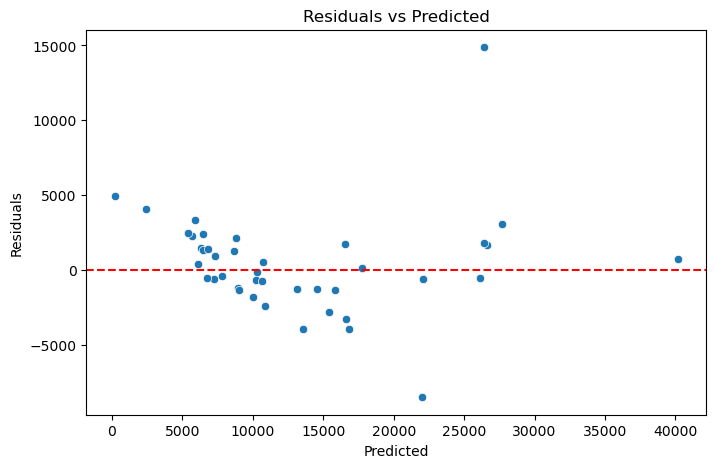

In [24]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_test, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

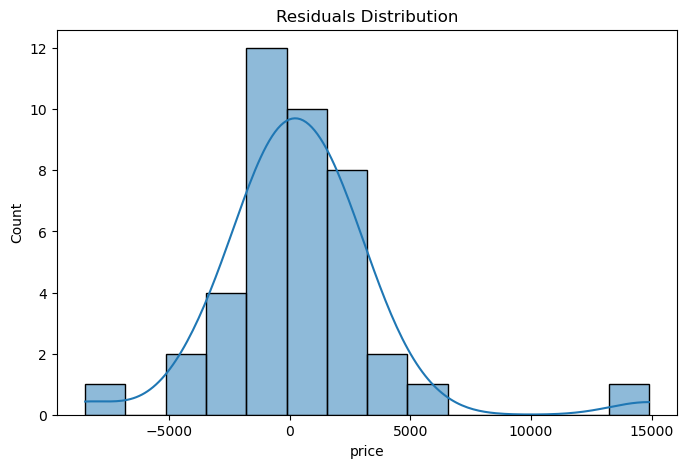

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

In [26]:
print("Mean residual:", residuals.mean())

Mean residual: 395.113972840841


## Regularization 

In [27]:
# Ridge GridSearch
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 5, 10, 20, 50, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 5, 10, 20, 50, 100]},
             scoring='r2')

In [28]:
print("Ridge best alpha:", ridge_grid.best_params_)
print("Ridge best CV R2:", ridge_grid.best_score_)

Ridge best alpha: {'alpha': 5}
Ridge best CV R2: 0.8586524784404486


In [29]:
# Final ridge
ridge_best = Ridge(alpha=ridge_grid.best_params_['alpha'])
ridge_best.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_best.predict(X_test_scaled)

In [30]:
print("Ridge Test R²:", r2_score(y_test, y_pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))


Ridge Test R²: 0.8530411312510204
Ridge RMSE: 3406.100997177023


## Lasso

In [31]:
#Lasso GridSearch
lasso = Lasso(max_iter=20000)
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=20000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]},
             scoring='r2')

In [32]:
print("Lasso best alpha:", lasso_grid.best_params_)
print("Lasso best CV R2:", lasso_grid.best_score_)

Lasso best alpha: {'alpha': 20}
Lasso best CV R2: 0.8555039903949136


In [33]:
# Final lasso
lasso_best = Lasso(alpha=lasso_grid.best_params_['alpha'], max_iter=20000)
lasso_best.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_best.predict(X_test_scaled)

In [34]:
print("Lasso Test R²:", r2_score(y_test, y_pred_lasso))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Lasso Test R²: 0.8584033412361187
Lasso RMSE: 3343.3829553231876


## Final Model

In [35]:
final_model = lasso_best 

In [36]:
y_pred_final = final_model.predict(X_test_scaled)

In [37]:
print("---- Final Model Evaluation ----")
print("Test R²:", r2_score(y_test, y_pred_final))
print("MAE:", mean_absolute_error(y_test, y_pred_final))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_final)))

---- Final Model Evaluation ----
Test R²: 0.8584033412361187
MAE: 2195.0809105667263
RMSE: 3343.3829553231876


## Visualization

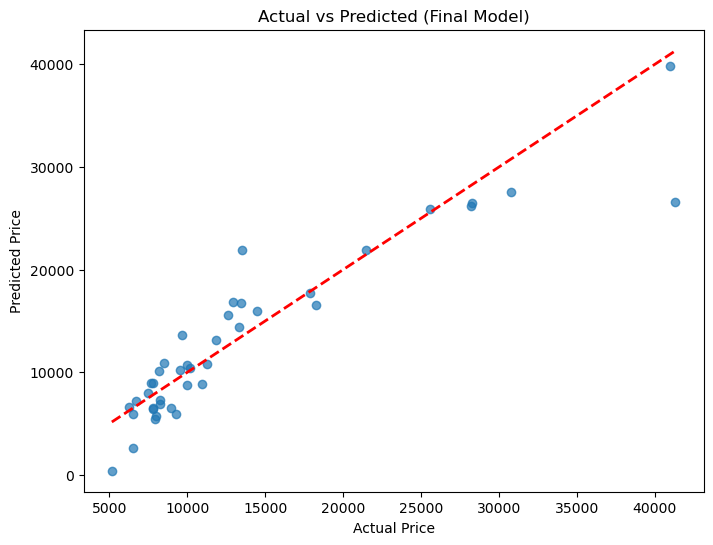

In [39]:
# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_final, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Final Model)")
plt.show()